In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
experiment_data_folders_path = os.path.join(os.getcwd(), "Data", "Experiment")
print(experiment_data_folders_path)

/home/jovyan/Masterarbeit/Data/Experiment


In [3]:
# for files with a single column of data
def read_lines_from_file_into_df(file_path, column_names):
    # Read all lines from the file
    with open(file_path, "r") as f:
        lines = f.readlines()
    
    # Strip any whitespace characters from the ends of the lines
    data = [line.strip() for line in lines]
    
    # Create a DataFrame from the data
    df = pd.DataFrame([data], columns=column_names)
    
    return df

# for files with multiple columns of data
def get_df_from_file(file_path, column_names):
    df = pd.read_csv(file_path, sep='\t', header=None, names = column_names)
    return df

# for files with a single data point
def read_first_line_from_file(file_path):
    lines = []
    with open(file_path, "r") as f:
        for line in f:
            lines.append(line)

    return lines[0]

def get_movement_timestamps_df_from_interaction_events_df(interaction_events_df):
    grab_events = interaction_events_df[interaction_events_df['EventType'] == 'Grab']
    release_events = interaction_events_df[interaction_events_df['EventType'] == 'Release']
    
    grab_events = grab_events.reset_index(drop=True)
    release_events = release_events.reset_index(drop=True)

    movement_timestamps_df = pd.DataFrame({
        'GrabTimestamp': grab_events['Timestamp'],
        'ReleaseTimestamp': release_events['Timestamp']
    })

    return movement_timestamps_df

def calculate_distance_and_speed(grab_timestamp, release_timestamp, movement_df):
    # Filter the movement data between the grab and release timestamps
    movement_data = movement_df[(movement_df['Timestamp'] >= grab_timestamp) & (movement_df['Timestamp'] <= release_timestamp)]
    
    distances = np.sqrt((movement_data['PositionX'].diff()**2) + 
                        (movement_data['PositionY'].diff()**2) + 
                        (movement_data['PositionZ'].diff()**2))
    
    total_distance = distances.sum()
    
    time_duration = release_timestamp - grab_timestamp
    
    # Calculate speed (distance / time)
    average_speed = total_distance / time_duration if time_duration > 0 else 0
    
    return total_distance, average_speed

def get_grip_pressure(grab_timestamp, release_timestamp, movement_df):
    # subtract a tolerance (seconds) from grab_timestamp, as grip pressure can rise before item is fully grabbed 
    tolerance = 0.5
    movement_data = movement_df[(movement_df['Timestamp'] >= grab_timestamp - tolerance) & (movement_df['Timestamp'] <= release_timestamp)]
    grip_pressure = movement_data['GripPressure'].mean()
    #print(grip_pressure)

    return grip_pressure

def get_round_number(grab_timestamp, round_data):
    for i, row in round_data.iterrows():
        if grab_timestamp <= row['RoundEndTimestamp']:
            return row['RoundNumber']
    return None

def get_correctly_moved_items_percentages(round_data_df):
    percentages = []
    for i in range(len(round_data_df)):  # Get all available rounds
        percentage = round_data_df.iloc[i]['CorrectItems'] / round_data_df['TotalItems']
        percentages.append(percentage)
    return percentages

In [56]:
NUMBER_OF_ROUNDS = 10

participants_df = pd.DataFrame()

# Iterate through each folder in the directory
for folder_name in os.listdir(experiment_data_folders_path):
    # Skip if it's not a directory or if it's a hidden/system directory (starts with '.')
    if not os.path.isdir(os.path.join(experiment_data_folders_path, folder_name)) or folder_name.startswith('.'):
        continue

    print('folder name: ' + folder_name)
    
    folder_path = os.path.join(experiment_data_folders_path, folder_name)

    interaction_events_df = get_df_from_file(os.path.join(folder_path, 'InteractionEvents.txt'), 
                                             ['Timestamp', 'EventType', 'Interactor', 'Interactable'])
    interaction_events_df['Timestamp'] = interaction_events_df['Timestamp'].map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
    interaction_events_df = interaction_events_df.astype({'Timestamp': 'float'})

    #print(interaction_events_df.head())

    movement_timestamps_df = get_movement_timestamps_df_from_interaction_events_df(interaction_events_df)

    #print(movement_timestamps_df.head())
    
    dominant_hand = read_first_line_from_file(os.path.join(folder_path, 'DominantHand.txt'))

    if not os.path.exists(os.path.join(folder_path, dominant_hand + '.txt')):
        print('No movement data, skipping data participant data set')
        continue
                           
    dominant_hand_movement_df = get_df_from_file(os.path.join(folder_path, dominant_hand + '.txt'), 
                                                ['Timestamp', 'PositionX', 'PositionY', 'PositionZ', 
                                                 'RotationX', 'Rotation Y', 'RotationZ', 'RotationW', 
                                                 'GripPressure'])

    dominant_hand_movement_df = dominant_hand_movement_df.apply(lambda col: col.map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x))
    dominant_hand_movement_df = dominant_hand_movement_df.astype('float')

    distances = []
    speeds = []
    grip_pressures = []
    
    # Iterate through each row in movement_timestamps_df
    for index, row in movement_timestamps_df.iterrows():
        grab_timestamp = row['GrabTimestamp']
        release_timestamp = row['ReleaseTimestamp']
        distance, speed = calculate_distance_and_speed(grab_timestamp, release_timestamp, dominant_hand_movement_df)
        grip_pressure = get_grip_pressure(grab_timestamp, release_timestamp, dominant_hand_movement_df)
        distances.append(distance)
        speeds.append(speed)
        grip_pressures.append(grip_pressure)

    # Add the results to the DataFrame
    movement_timestamps_df['Distance'] = distances
    movement_timestamps_df['Speed'] = speeds
    movement_timestamps_df['GripPressure'] = grip_pressures

    #print(movement_timestamps_df)
    
    round_data_df = get_df_from_file(os.path.join(folder_path, 'RoundData.txt'), 
                                    ['RoundEndTimestamp', 'RoundNumber', 'RoundType', 'CorrectItems', 'TotalItems'])
    round_data_df['RoundEndTimestamp'] = round_data_df['RoundEndTimestamp'].map(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
    round_data_df = round_data_df.astype({'RoundEndTimestamp': 'float'})

    movement_timestamps_df['RoundNumber'] = movement_timestamps_df['GrabTimestamp'].apply(lambda x: get_round_number(x, round_data_df))

    #print(movement_timestamps_df.head())
  
    # df containing raw survey answers
    survey_answers_raw_df = read_lines_from_file_into_df(os.path.join(folder_path, 'SurveyAnswers.txt'), 
                                                     ['GeneralCheck', 
                                                    'CLMentalDemand', 'CLPhysicalDemand', 'CLTemporalDemand', 
                                                    'CLPerformance', 'CLEffort', 'CLFrustration',                                     
                                                    'LeftHandConsciousMovement', 'RightHandConsciousMovement',
                                                    'Presence1', 'Presence2', 'Presence3', 'Presence4', 'Presence5', 'Presence6',
                                                    'ExperienceVR1', 'ExperienceVR2', 'ExperienceVR3',
                                                    'NauseaNausea', 'NauseaDizziness', 
                                                    'VestibularDisorientation', 'VestibularImbalance',
                                                    'OculomotorFatigue', 'OculomotorDiscomfort',
                                                    'Gender', 'Education', 'EmployementStatus', 'Age'
                                                   ])


    # convert all to int except GeneralCheck, Gender, Education and EmploymentStatus
    survey_answers_raw_df = survey_answers_raw_df.astype({'CLMentalDemand': 'int32', 'CLPhysicalDemand': 'int32', 'CLTemporalDemand': 'int32', 
                                                          'CLPerformance': 'int32', 'CLEffort': 'int32', 'CLFrustration': 'int32', 
                                                          'LeftHandConsciousMovement': 'int32', 'RightHandConsciousMovement': 'int32',
                                                          'Presence1': 'int32', 'Presence2': 'int32', 'Presence3': 'int32', 'Presence4': 'int32', 'Presence5': 'int32', 'Presence6': 'int32',
                                                          'ExperienceVR1': 'int32', 'ExperienceVR2': 'int32', 'ExperienceVR3': 'int32',
                                                          'NauseaNausea': 'int32', 'NauseaDizziness': 'int32', 'VestibularDisorientation': 'int32', 'VestibularImbalance': 'int32',
                                                          'OculomotorFatigue': 'int32', 'OculomotorDiscomfort': 'int32',
                                                          'Age': 'int32'
                                                         })
    
    # df containing calculated values of constructs
    survey_answers_df = pd.DataFrame()
    survey_answers_df['GeneralCheck'] = survey_answers_raw_df['GeneralCheck']
    survey_answers_df['CLMentalDemand'] = survey_answers_raw_df['CLMentalDemand']
    survey_answers_df['CLPhysicalDemand'] = survey_answers_raw_df['CLPhysicalDemand']
    survey_answers_df['CLTemporalDemand'] = survey_answers_raw_df['CLTemporalDemand']
    survey_answers_df['CLPerformance'] = survey_answers_raw_df['CLPerformance']
    survey_answers_df['CLEffort'] = survey_answers_raw_df['CLEffort']
    survey_answers_df['CLFrustration'] = survey_answers_raw_df['CLFrustration']
    survey_answers_df['NASA-TLX'] = (survey_answers_raw_df['CLMentalDemand'] + survey_answers_raw_df['CLPhysicalDemand'] + survey_answers_raw_df['CLTemporalDemand'] + survey_answers_raw_df['CLPerformance'] + survey_answers_raw_df['CLEffort'] + survey_answers_raw_df['CLFrustration']) / 6
    survey_answers_df['LeftHandConsciousMovement'] = survey_answers_raw_df['LeftHandConsciousMovement']
    survey_answers_df['RightHandConsciousMovement'] = survey_answers_raw_df['RightHandConsciousMovement']
    survey_answers_df['Presence'] = (survey_answers_raw_df['Presence1'] + survey_answers_raw_df['Presence2'] + survey_answers_raw_df['Presence3'] + survey_answers_raw_df['Presence4'] + survey_answers_raw_df['Presence5'] + survey_answers_raw_df['Presence6']) / 6
    survey_answers_df['ExperienceVR'] = (survey_answers_raw_df['ExperienceVR1'] + survey_answers_raw_df['ExperienceVR2'] + survey_answers_raw_df['ExperienceVR3']) / 3
    survey_answers_df['CSQ-VR-Nausea'] = survey_answers_raw_df['NauseaNausea'] + survey_answers_raw_df['NauseaDizziness']
    survey_answers_df['CSQ-VR-Vestibular'] = survey_answers_raw_df['VestibularDisorientation'] + survey_answers_raw_df['VestibularImbalance']
    survey_answers_df['CSQ-VR-Oculomotor'] = survey_answers_raw_df['OculomotorFatigue'] + survey_answers_raw_df['OculomotorDiscomfort']
    survey_answers_df['CSQ-VR'] = survey_answers_df['CSQ-VR-Nausea'] + survey_answers_df['CSQ-VR-Vestibular'] + survey_answers_df['CSQ-VR-Oculomotor']
    survey_answers_df['Gender'] = survey_answers_raw_df['Gender']
    survey_answers_df['Education'] = survey_answers_raw_df['Education']
    survey_answers_df['EmployementStatus'] = survey_answers_raw_df['EmployementStatus']
    survey_answers_df['Age'] = survey_answers_raw_df['Age']

    treatment_type = read_first_line_from_file(os.path.join(folder_path, 'TreatmentType.txt'))
    # for some reason, the treatment type file always has a newline character at the end
    treatment_type = treatment_type.replace('\n', '')

    tutorial_time = read_first_line_from_file(os.path.join(folder_path, 'TutorialTime.txt'))
    tutorial_time = float(tutorial_time.replace(',', '.'))
    
    participant_df = pd.DataFrame({'FolderName': folder_name,
                                   'TreatmentType': treatment_type,
                                   'TutorialTime': tutorial_time,
                                   'MeanDistDomHand': movement_timestamps_df['Distance'].mean(),
                                   'MeanSpeedDomHand': movement_timestamps_df['Speed'].mean(),
                                   'MeanGripPressureDomHand': movement_timestamps_df['GripPressure'].mean(),
                                  }, index=[0])

    round_data_df = round_data_df.astype({'RoundEndTimestamp': 'float'})

    # Group by RoundNumber and calculate mean values
    round_means_df = movement_timestamps_df.groupby('RoundNumber').agg({
        'Distance': 'mean',
        'Speed': 'mean',
        'GripPressure': 'mean'
    }).reset_index()
    #print(round_means_df)
    
    # Add mean Distance, Speed and GripPressure columns for each round
    for _, row in round_means_df.iterrows():
        round_number = int(row['RoundNumber'])
        participant_df[f'MeanDistanceRound{round_number}'] = row['Distance']
        participant_df[f'MeanSpeedRound{round_number}'] = row['Speed']
        participant_df[f'MeanGripPressureRound{round_number}'] = row['GripPressure']

    correct_percentages = get_correctly_moved_items_percentages(round_data_df)

    # Add the correctly moved item percentage columns dynamically
    for i in range(len(correct_percentages)):
        participant_df[f'CorrectlyMovedPercentageRound{i+1}'] = correct_percentages[i]
    
    participant_df['CorrectlyMovedPercentageMean'] = np.mean(correct_percentages)
    
    participant_df = pd.concat([participant_df.reset_index(drop=True), survey_answers_df.reset_index(drop=True)], axis=1)
        
    participants_df = pd.concat([participants_df, participant_df], ignore_index = True)
    
#print(participants_df.head())
participants_df.to_csv('Experiment.csv', sep = ';', decimal = ',', index=False)

folder name: 75581aef-d32d-46a5-b9f2-095f0cac184b
folder name: d948c4ad-defd-46a9-abd5-5240cfe5899c
folder name: 7399bae9-796c-4a26-9991-5917c26b1223
folder name: b9bb74b1-46a7-497a-9ea1-8ce4a3d00613
folder name: bd05dee3-2ee6-4122-84c8-b597aa6eaa94
folder name: bee3c7bb-9d0c-4938-b244-0d3376c31721
folder name: 2405f21a-bdfb-42bc-95ae-1c6657f2a03d
folder name: d3ad9ccf-ef46-4276-8363-75d652ef2fbb
folder name: 72808563-2c2c-4913-b5ec-2439e8141bbe
folder name: b1c93b16-0328-4830-8a70-704457367ece
No movement data, skipping data participant data set
folder name: 8ff30652-6b8e-49a2-8cb5-de9af5e64705
folder name: ddea3ca7-bc96-41ab-9cfa-c99e50297a2e
folder name: 827068f3-0085-4437-ab51-d06b25fba03f
folder name: 96b39d34-f56d-4055-b7b0-2768a21ed318
folder name: d29b3590-6b60-4622-bcc7-c30b5325af80
folder name: 980e327b-82e4-4816-a0f3-e4beabf8fd86
folder name: aaae5fe8-3e5f-461b-9bc2-6f6221c410b9
folder name: 3143519e-d3e8-472e-b766-de7841d75145
folder name: b6c6f584-4a94-417c-b3a2-4a682bfce4

In [57]:
import scipy.stats as stats

def print_participant_statistics(df):
    print("-" * 50)
    print('TutorialTime')

    # Tutorial time histogram
    plt.hist(df['TutorialTime'], bins=30)
    plt.xlabel('Tutorial Time')
    plt.ylabel('Frequency')
    plt.show()
    
    # Tutorial time boxplot
    df.boxplot(column='TutorialTime')
    plt.ylabel('Tutorial Time')
    plt.title('Boxplot of Tutorial Time')
    plt.show()
    print("-" * 50)

    low_cl_participants_count = np.sum(df['TreatmentType'] == 'LowCognitiveLoad')
    high_cl_participants_count = np.sum(df['TreatmentType'] == 'HighCognitiveLoad')
    print('Low CL: ' + str(low_cl_participants_count) + ', High CL: ' + str(high_cl_participants_count))

    mean_age = df['Age'].mean()
    print('Mean age: ' + str(mean_age))
    
    gender_counts = df['Gender'].value_counts()
    education_counts = df['Education'].value_counts()
    employment_counts = df['EmployementStatus'].value_counts()
    
    # Plotting demographics
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Gender
    axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    axes[0].set_title('Gender Distribution')
    
    # Education
    axes[1].pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    axes[1].set_title('Education Level Distribution')
    
    # Employment Status
    axes[2].pie(employment_counts, labels=employment_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
    axes[2].set_title('Employment Status Distribution')

    plt.show()
    print("-" * 50)

def print_t_test(df, column_name, highClMeanGreaterOrLess):
    alpha = 0.05
    
    # Levene test
    data_low_cl = df.loc[df['TreatmentType'] == 'LowCognitiveLoad', column_name]
    data_high_cl = df.loc[df['TreatmentType'] == 'HighCognitiveLoad', column_name]
    levene_test = stats.levene(data_low_cl, data_high_cl)
    print(levene_test)
    
    isEqualVariance = False
    if(levene_test.pvalue < alpha):
        isEqualVariance = False
        print('Unequal variance')

    else:
        isEqualVariance = True
        print('Equal variance')

    print('')

    t_test = stats.ttest_ind(data_high_cl, data_low_cl, equal_var = isEqualVariance)
    print(t_test)
    if(t_test.pvalue < alpha):
        print('🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾')

        t_test = stats.ttest_ind(data_high_cl, data_low_cl, equal_var = isEqualVariance, alternative = highClMeanGreaterOrLess)
        print(t_test)
        if(t_test.pvalue < alpha):
            print('High CL mean significantly ' + highClMeanGreaterOrLess.upper() + ' than low CL mean')
        else:
            print('Effect seems to be the other way around')
    
    else:
        print('No significant difference between the groups')

def print_boxplot(df, column_name, y_limits):
     # Ensure 'TreatmentType' is treated as a categorical variable with a specific order
    df['TreatmentType'] = pd.Categorical(df['TreatmentType'], categories=['LowCognitiveLoad', 'HighCognitiveLoad'], ordered=True)
    
    df.boxplot(column=column_name, by='TreatmentType', grid=False)
    plt.ylim(y_limits)
    plt.suptitle('')
    plt.title('') 
    plt.ylabel(column_name)
    plt.xlabel('Group')
    plt.savefig(os.path.join(figures_path, column_name + '.png'))
    plt.show()

def print_descriptive_statistics(df, column_name):
    for group in df['TreatmentType'].unique():
        group_data = df[df['TreatmentType'] == group][column_name]
        median = np.median(group_data)
        mean = np.mean(group_data)
        sd = np.std(group_data)
        q1 = np.percentile(group_data, 25)
        q3 = np.percentile(group_data, 75)
        iqr = np.percentile(group_data, 75) - np.percentile(group_data, 25)
        print(f"Group: {group}")
        print(f"Median: {median}")
        print(f"Mean: {mean}")
        print(f"SD: {mean}")
        print(f"Q1: {q1}")
        print(f"Q3: {q3}")
        print(f"IQR: {iqr}")
        print("-" * 30)

def print_column_analysis(df, column_name, highClMeanGreaterOrLess, y_limits):
    print(column_name)
    print_boxplot(df, column_name, y_limits)
    print("-" * 30)

    print_descriptive_statistics(df, column_name)
    print_t_test(df, column_name, highClMeanGreaterOrLess)
    print("-" * 30)


def print_mean_per_round(df, round_column_base_name, y_limits):
    # Calculate regression lines

    # Convert all relevant columns to numeric, coercing errors to NaN
    rounds = [f'{round_column_base_name}{i}' for i in range(1, 11)]
    
    # Extract CorrectlyMovedPercentage for all rounds
    all_rounds = df[rounds].mean()
    
    # Extract CorrectlyMovedPercentage for LowCognitiveLoad
    low_cognitive_load = df[df['TreatmentType'] == 'LowCognitiveLoad'][rounds].mean()
    
    # Extract CorrectlyMovedPercentage for HighCognitiveLoad
    high_cognitive_load = df[df['TreatmentType'] == 'HighCognitiveLoad'][rounds].mean()
    
    # X values for plotting
    x_values = np.arange(1, 11)
    
    plt.figure(figsize=(12, 8))
    plt.ylim(y_limits)
    plt.plot(x_values, all_rounds, label='All participants', marker='o')
    plt.plot(x_values, low_cognitive_load, label='Low Cognitive Load', marker='o')
    plt.plot(x_values, high_cognitive_load, label='High Cognitive Load', marker='o')

    plt.xlabel('Round')
    plt.ylabel(round_column_base_name)
    plt.legend()
    plt.grid(True)
    plt.xticks(range(1, 11))
    
    plt.show()

--------------------------------------------------
TutorialTime


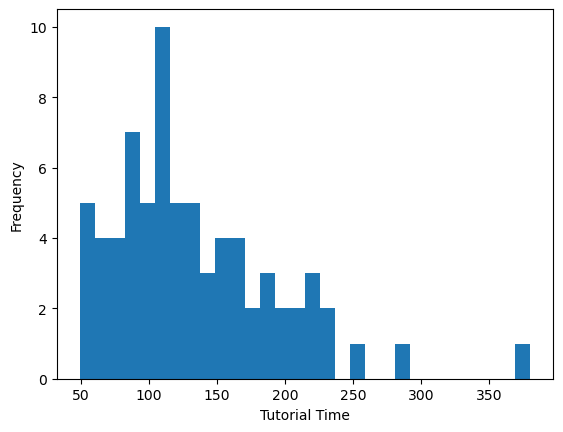

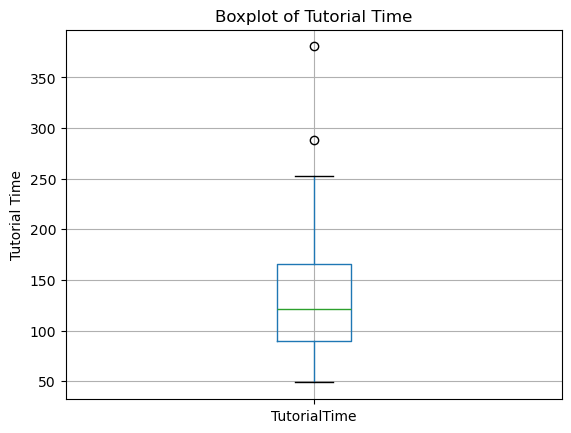

--------------------------------------------------
Low CL: 38, High CL: 35
Mean age: 37.24657534246575


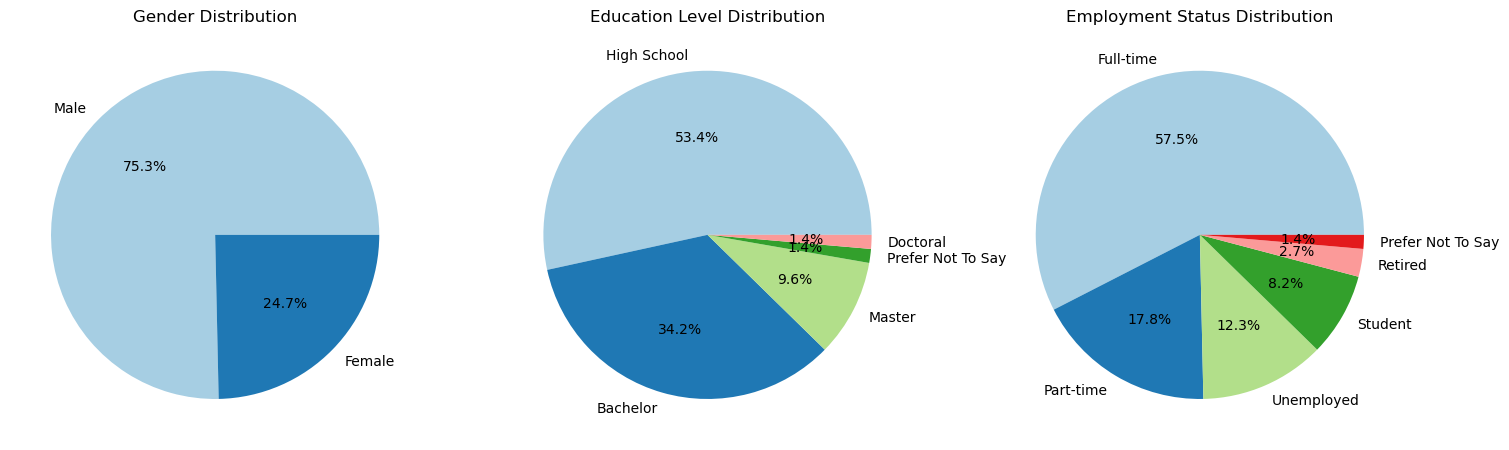

--------------------------------------------------
NASA-TLX


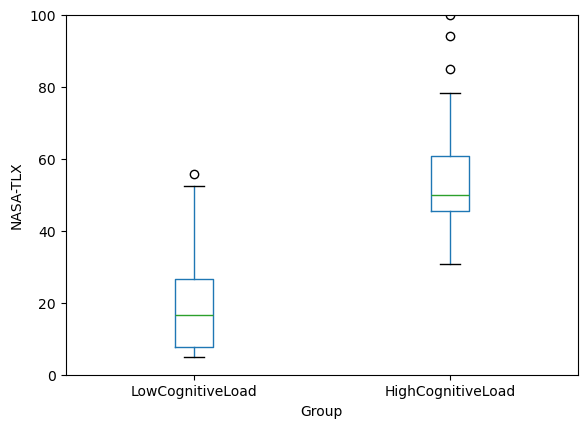

------------------------------
Group: LowCognitiveLoad
Median: 16.666666666666668
Mean: 20.67982456140351
SD: 20.67982456140351
Q1: 7.708333333333334
Q3: 26.666666666666668
IQR: 18.958333333333336
------------------------------
Group: HighCognitiveLoad
Median: 50.0
Mean: 54.714285714285715
SD: 54.714285714285715
Q1: 45.41666666666667
Q3: 60.83333333333333
IQR: 15.416666666666657
------------------------------
LeveneResult(statistic=0.17496216943848633, pvalue=0.6770013988070194)
Equal variance

TtestResult(statistic=9.373477959695276, pvalue=4.810143506722443e-14, df=71.0)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=9.373477959695276, pvalue=2.4050717533612214e-14, df=71.0)
High CL mean significantly GREATER than low CL mean
------------------------------


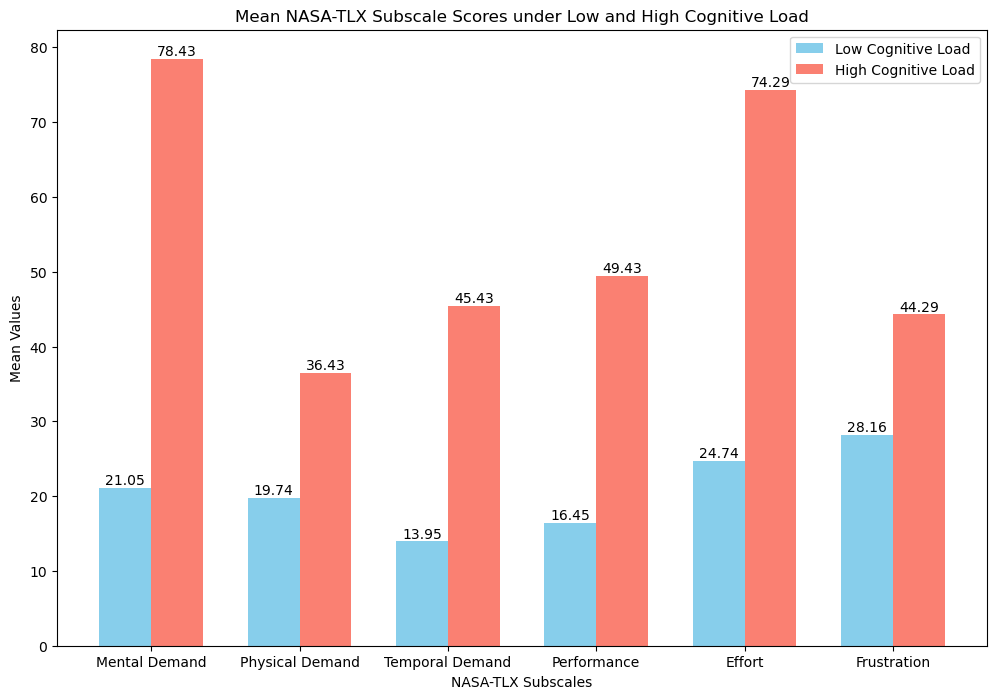

CorrectlyMovedPercentageMean


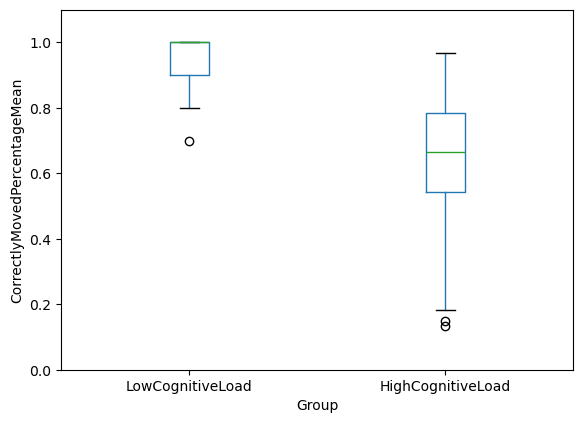

------------------------------
Group: LowCognitiveLoad
Median: 1.0
Mean: 0.9447368421052631
SD: 0.9447368421052631
Q1: 0.9
Q3: 1.0
IQR: 0.09999999999999998
------------------------------
Group: HighCognitiveLoad
Median: 0.6666666666666669
Mean: 0.6361904761904763
SD: 0.6361904761904763
Q1: 0.5416666666666667
Q3: 0.7833333333333334
IQR: 0.2416666666666667
------------------------------
LeveneResult(statistic=17.68807211746601, pvalue=7.482051169495731e-05)
Unequal variance

TtestResult(statistic=-7.737744205621592, pvalue=1.328034103290715e-09, df=41.88624041656465)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=-7.737744205621592, pvalue=6.640170516453575e-10, df=41.88624041656465)
High CL mean significantly LESS than low CL mean
------------------------------


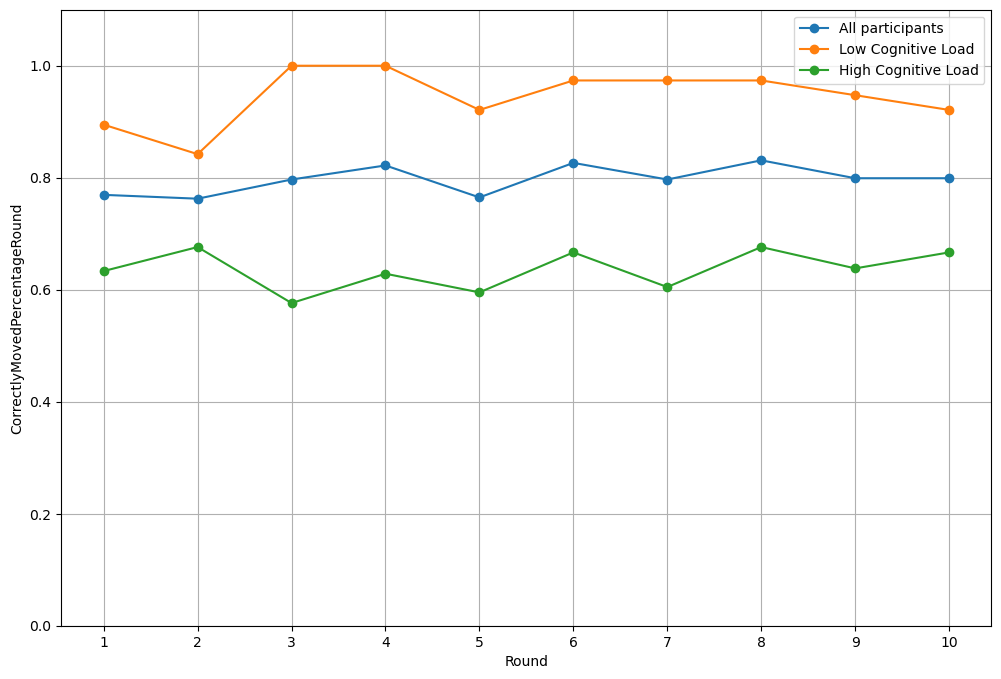

MeanDistDomHand


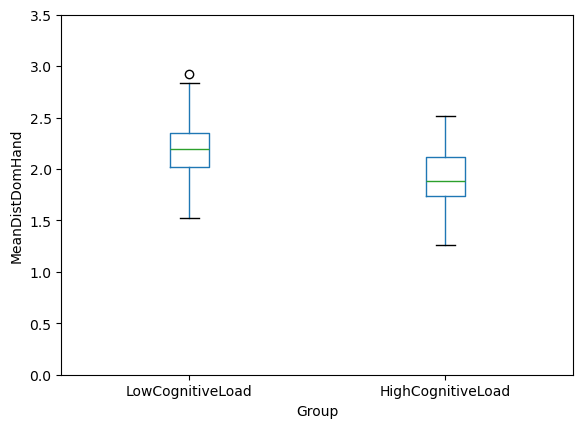

------------------------------
Group: LowCognitiveLoad
Median: 2.1962838602194235
Mean: 2.2461045166608584
SD: 2.2461045166608584
Q1: 2.0190292630489326
Q3: 2.3532327331021805
IQR: 0.3342034700532479
------------------------------
Group: HighCognitiveLoad
Median: 1.8834674446971316
Mean: 1.926606991698966
SD: 1.926606991698966
Q1: 1.7381561180415774
Q3: 2.1190254023252444
IQR: 0.38086928428366695
------------------------------
LeveneResult(statistic=0.2327339782261197, pvalue=0.6309880140388846)
Equal variance

TtestResult(statistic=-3.5837424050214453, pvalue=0.0006171961267614715, df=71.0)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=-3.5837424050214453, pvalue=0.9996914019366192, df=71.0)
Effect seems to be the other way around
------------------------------


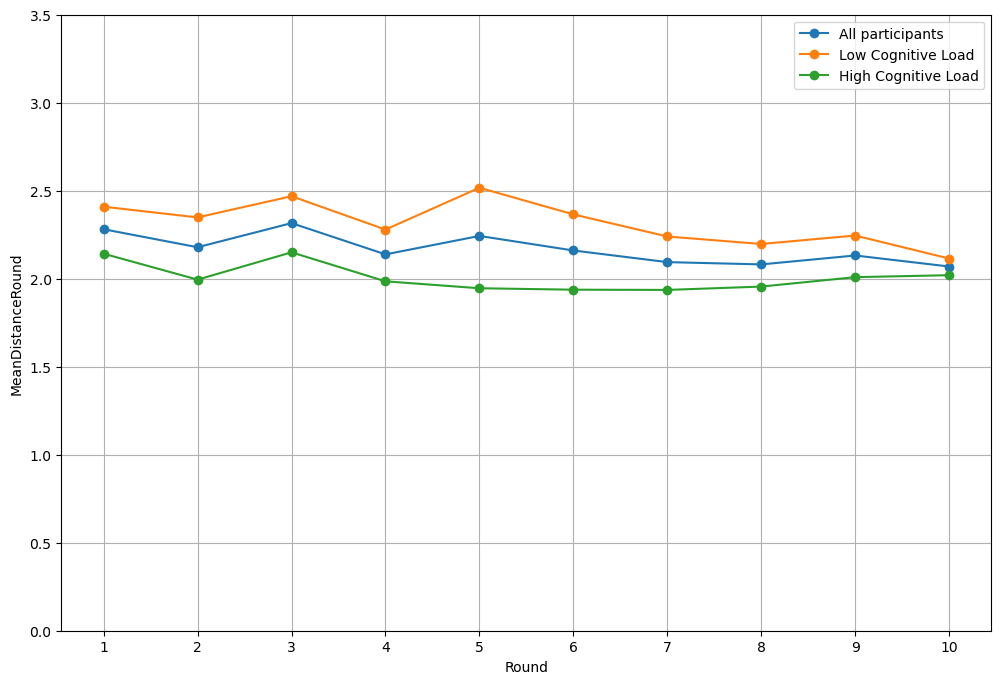

MeanSpeedDomHand


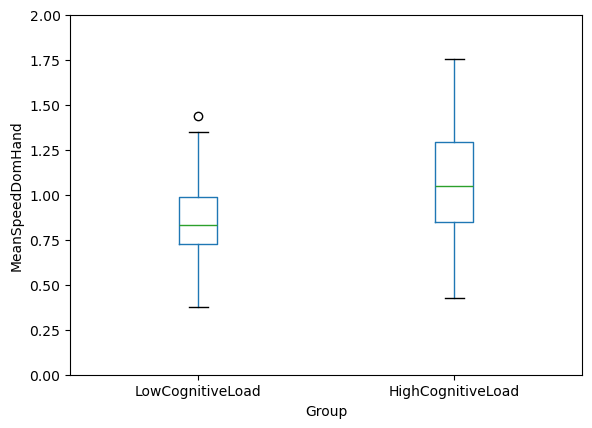

------------------------------
Group: LowCognitiveLoad
Median: 0.832009903164952
Mean: 0.8572398204323425
SD: 0.8572398204323425
Q1: 0.7251316498674255
Q3: 0.9892058615148976
IQR: 0.26407421164747213
------------------------------
Group: HighCognitiveLoad
Median: 1.0483773600741348
Mean: 1.0671675723514036
SD: 1.0671675723514036
Q1: 0.8495338003311086
Q3: 1.2915102507588
IQR: 0.4419764504276915
------------------------------
LeveneResult(statistic=5.325573520317437, pvalue=0.0239329820477581)
Unequal variance

TtestResult(statistic=3.312335007936955, pvalue=0.001557091922792932, df=61.126660500985594)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=3.312335007936955, pvalue=0.9992214540386035, df=61.126660500985594)
Effect seems to be the other way around
------------------------------


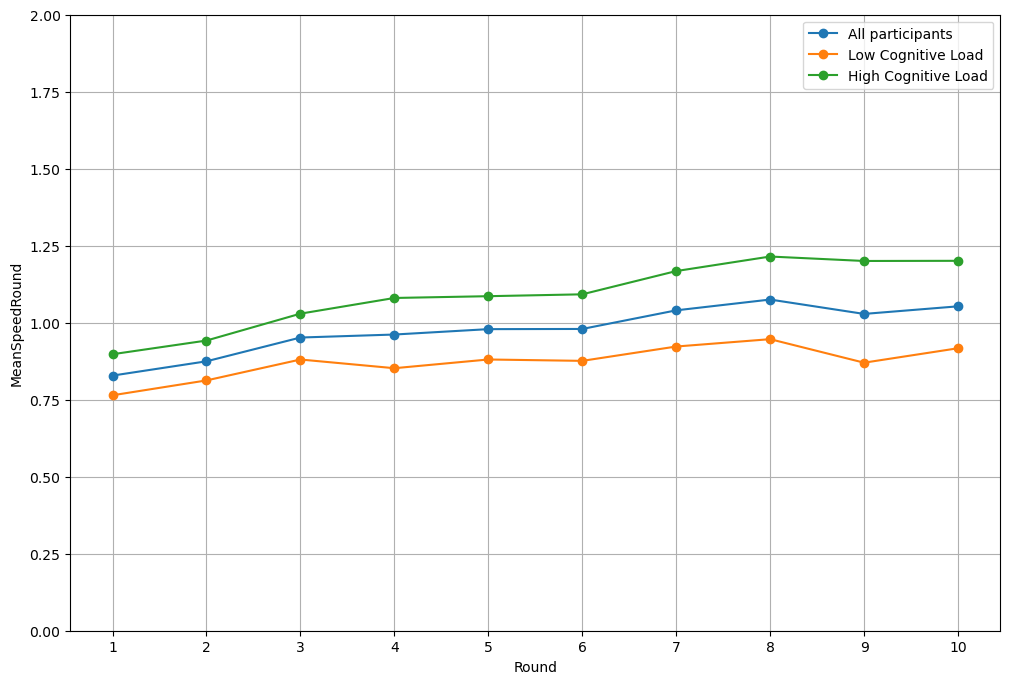

MeanGripPressureDomHand


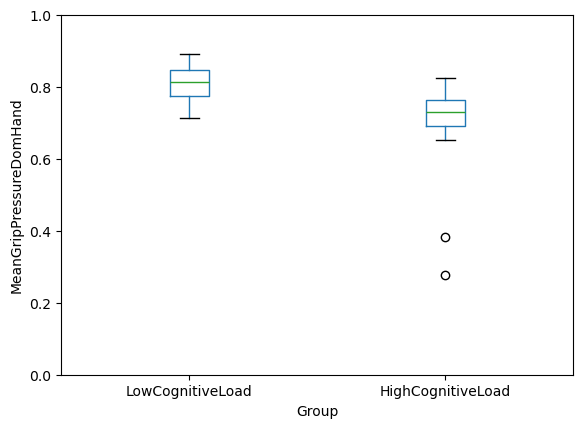

------------------------------
Group: LowCognitiveLoad
Median: 0.8138959936845411
Mean: 0.8073980665567779
SD: 0.8073980665567779
Q1: 0.7751963628127211
Q3: 0.8465846351064077
IQR: 0.0713882722936866
------------------------------
Group: HighCognitiveLoad
Median: 0.7287719172071032
Mean: 0.7122480321720094
SD: 0.7122480321720094
Q1: 0.6914400369298268
Q3: 0.7629573076381382
IQR: 0.07151727070831138
------------------------------
LeveneResult(statistic=1.5716964736485373, pvalue=0.21407321062631068)
Equal variance

TtestResult(statistic=-4.972605593786768, pvalue=4.42587262195361e-06, df=71.0)
🎉🥳🎈🎊🍾Significant difference between the groups 🎉🥳🎈🎊🍾
TtestResult(statistic=-4.972605593786768, pvalue=0.999997787063689, df=71.0)
Effect seems to be the other way around
------------------------------


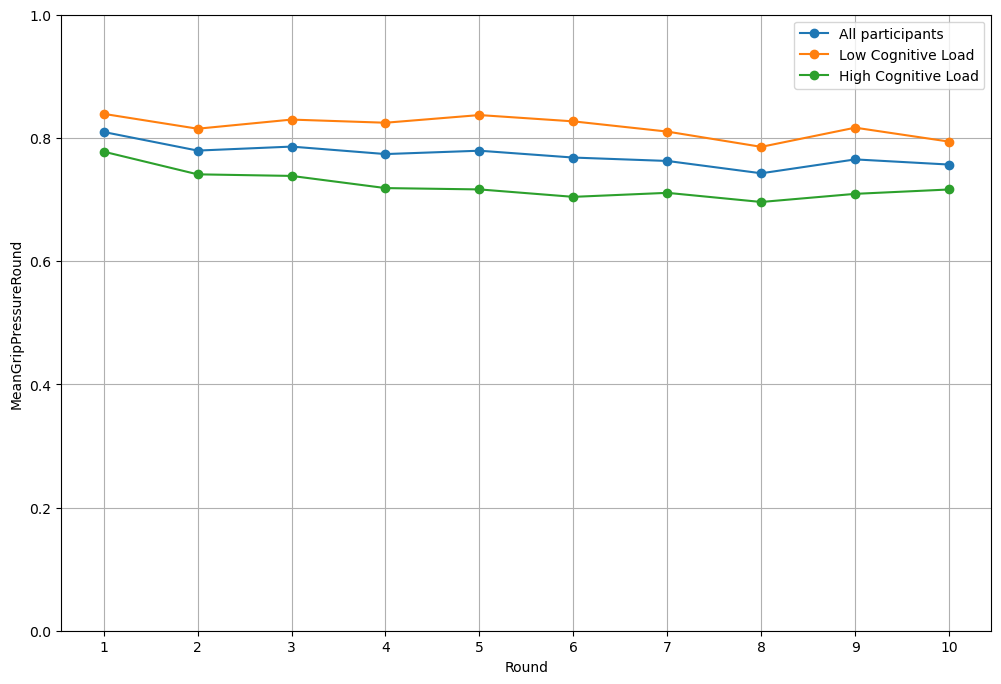

In [58]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Statistics, Visualizations and t-Tests

figures_path = os.path.join(os.getcwd(), "Figures")
df = participants_df

print_participant_statistics(df)

print_column_analysis(df, 'NASA-TLX', 'greater', [0, 100])

# Mean values for each subscale
subscales = ['Mental Demand', 'Physical Demand', 'Temporal Demand', 'Performance', 'Effort', 'Frustration']

# Mean values under low and high cognitive load
low_cl_means = [
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLMentalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLPhysicalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLTemporalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLPerformance'].mean(),
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLEffort'].mean(),
    df.loc[df['TreatmentType'] == 'LowCognitiveLoad', 'CLFrustration'].mean()
]

high_cl_means = [
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLMentalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLPhysicalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLTemporalDemand'].mean(),
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLPerformance'].mean(),
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLEffort'].mean(),
    df.loc[df['TreatmentType'] == 'HighCognitiveLoad', 'CLFrustration'].mean()
]

# X positions for the bars
x = range(len(subscales))

# Width of the bars
width = 0.35

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.bar(x, low_cl_means, width, label='Low Cognitive Load', color='skyblue')
plt.bar([p + width for p in x], high_cl_means, width, label='High Cognitive Load', color='salmon')

# Add labels, title, and legend
plt.xlabel('NASA-TLX Subscales')
plt.ylabel('Mean Values')
plt.title('Mean NASA-TLX Subscale Scores under Low and High Cognitive Load')
plt.xticks([p + width / 2 for p in x], subscales)
plt.legend()

# Add value labels on top of the bars
for i, v in enumerate(low_cl_means):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(high_cl_means):
    plt.text(i + width, v + 0.05, f'{v:.2f}', ha='center', va='bottom')

# Display the plot
plt.show()


print_column_analysis(df, 'CorrectlyMovedPercentageMean', 'less', [0, 1.1])
print_mean_per_round(df, 'CorrectlyMovedPercentageRound', [0, 1.1])

print_column_analysis(df, 'MeanDistDomHand', 'greater', [0, 3.5])
print_mean_per_round(df, 'MeanDistanceRound', [0, 3.5])

print_column_analysis(df, 'MeanSpeedDomHand', 'less', [0, 2])
print_mean_per_round(df, 'MeanSpeedRound', [0, 2])

print_column_analysis(df, 'MeanGripPressureDomHand', 'greater', [0,1])
print_mean_per_round(df, 'MeanGripPressureRound', [0,1])


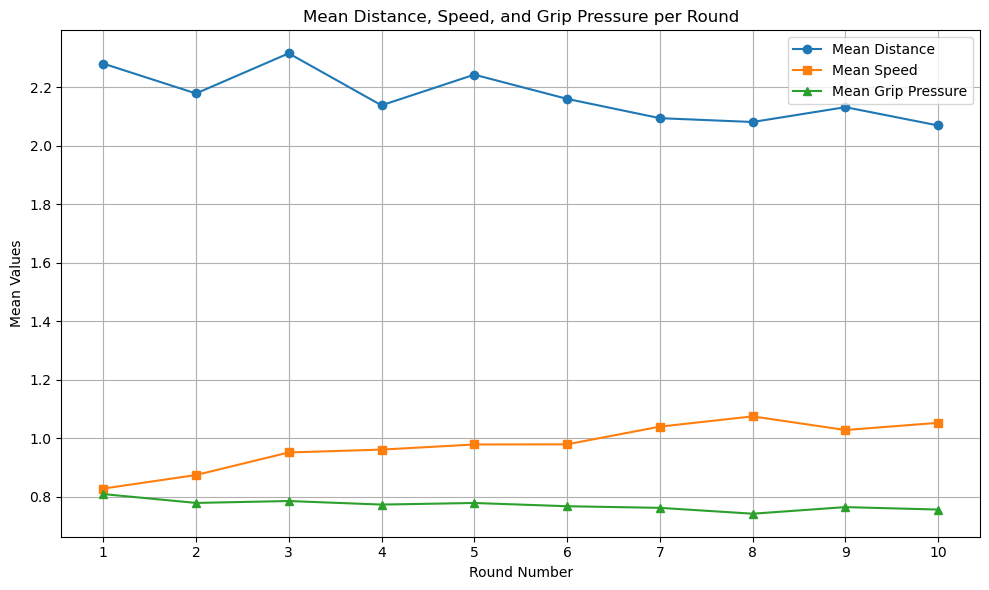

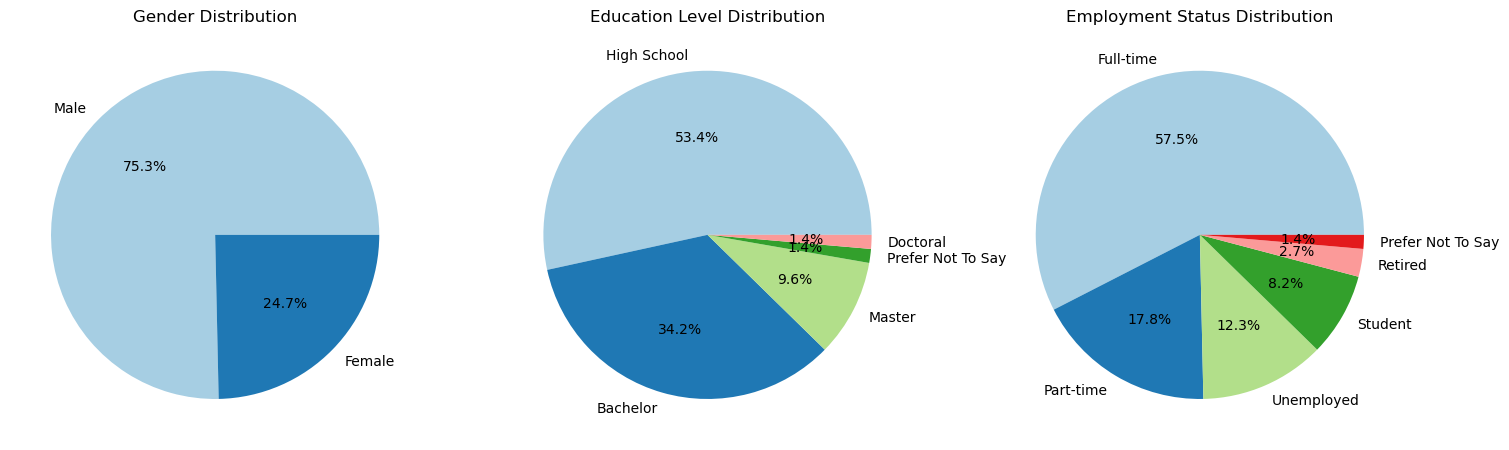

TreatmentType
HighCognitiveLoad    54.714286
LowCognitiveLoad     20.679825
Name: NASA-TLX, dtype: float64


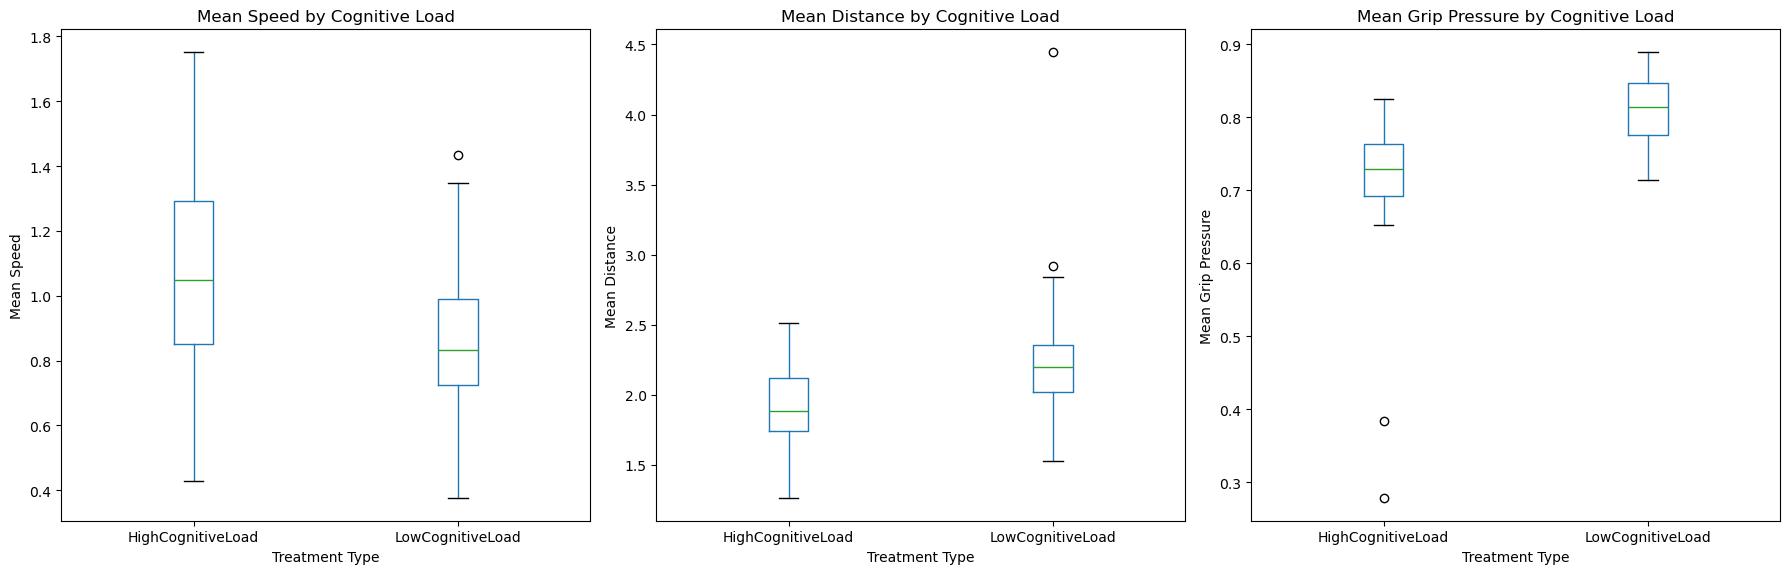

KeyError: 'Column not found: MeanMistakePercentage'

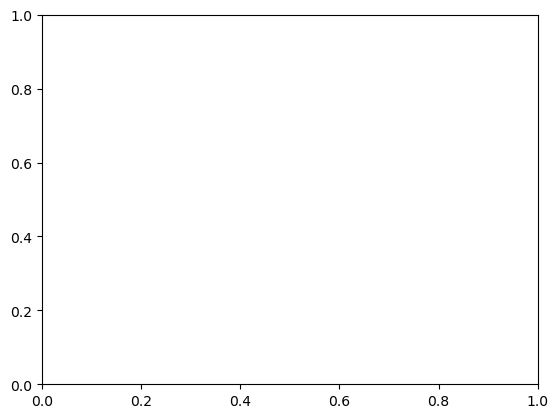

In [38]:
import matplotlib.pyplot as plt

# Statistics and Visualizations

df = participants_df

rounds = range(1, NUMBER_OF_ROUNDS + 1)
mean_distance = [df[f'MeanDistanceRound{round}'].mean() for round in rounds]
mean_speed = [df[f'MeanSpeedRound{round}'].mean() for round in rounds]
mean_grip_pressure = [df[f'MeanGripPressureRound{round}'].mean() for round in rounds]

# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(rounds, mean_distance, marker='o', label='Mean Distance')
plt.plot(rounds, mean_speed, marker='s', label='Mean Speed')
plt.plot(rounds, mean_grip_pressure, marker='^', label='Mean Grip Pressure')

plt.xlabel('Round Number')
plt.ylabel('Mean Values')
plt.title('Mean Distance, Speed, and Grip Pressure per Round')
plt.legend()
plt.grid(True)
plt.xticks(rounds)  # Set x-axis to show round numbers
plt.tight_layout()

# Save or show the plot
#plt.savefig('participants_mean_plot.png')  # To save the plot as a file
plt.show()  # To display the plot

gender_counts = df['Gender'].value_counts()
education_counts = df['Education'].value_counts()
employment_counts = df['EmployementStatus'].value_counts()

# Plotting demographics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gender
axes[0].pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[0].set_title('Gender Distribution')

# Education
axes[1].pie(education_counts, labels=education_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[1].set_title('Education Level Distribution')

# Employment Status
axes[2].pie(employment_counts, labels=employment_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
axes[2].set_title('Employment Status Distribution')

plt.show()

nasa_tlx_mean_by_load = df.groupby('TreatmentType')['NASA-TLX'].mean()

# Display the results
print(nasa_tlx_mean_by_load)


# Plotting mean speed, distance, and grip pressure by cognitive load using boxplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for Mean Speed
df.boxplot(column='MeanSpeedDomHand', by='TreatmentType', ax=axes[0], grid=False)
axes[0].set_title('Mean Speed by Cognitive Load')
axes[0].set_xlabel('Treatment Type')
axes[0].set_ylabel('Mean Speed')

# Boxplot for Mean Distance
df.boxplot(column='MeanDistDomHand', by='TreatmentType', ax=axes[1], grid=False)
axes[1].set_title('Mean Distance by Cognitive Load')
axes[1].set_xlabel('Treatment Type')
axes[1].set_ylabel('Mean Distance')

# Boxplot for Mean Grip Pressure
df.boxplot(column='MeanGripPressureDomHand', by='TreatmentType', ax=axes[2], grid=False)
axes[2].set_title('Mean Grip Pressure by Cognitive Load')
axes[2].set_xlabel('Treatment Type')
axes[2].set_ylabel('Mean Grip Pressure')

# Adjust layout to avoid overlapping titles
fig.suptitle('')
plt.tight_layout()
plt.show()


df.boxplot(column='MeanMistakePercentage', by='TreatmentType')
plt.show()